In [8]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

DATA_DIR = "../external"
CSV_FILE = "imudataset.csv"
ACTIVITY_MAP = {
    4: 0,  # sitting → "Sit"
    3: 1,  # walking → "Walk"
    1: 2   # walking upstairs → "Upstairs"
}
ACTIVITIES = ["Sit", "Walk", "Upstairs"]

SAMPLING_RATE = 50 # The IMU dataset collects data at 50hz instead of 100hz
OVERLAP = 0.5
CHUNK_SIZE = 1  
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

In [4]:
def load_activity_data(trial_length_sec=10):
    file_path = os.path.join(DATA_DIR, CSV_FILE)
    df = pd.read_csv(file_path)
    df.columns = ["ax", "ay", "az", "gx", "gy", "gz", "label"]
    df = df[df["label"].isin(ACTIVITY_MAP.keys())] # Filters only activities that we want to use
    samples_per_trial = trial_length_sec * SAMPLING_RATE
    data_raw, labels = [], []
    for label_id, mapped_id in ACTIVITY_MAP.items():
        df_activity = df[df["label"] == label_id].drop(columns=["label"]).reset_index(drop=True)
        # Break into multiple trials as dataset is small
        for start in range(0, len(df_activity), samples_per_trial):
            chunk = df_activity.iloc[start:start + samples_per_trial]
            if len(chunk) == samples_per_trial:
                data_raw.append(chunk)
                labels.append(mapped_id)
    return data_raw, labels

def chunk_data_raw(data_raw, labels, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    data, y = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))
    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start+chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk.values)
                y.append(labels[i])
    return np.array(data), np.array(y)

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=6, emb_size=32, nhead=4, nhid=64, nlayers=2, nclasses=len(ACTIVITIES), dropout=0.3):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, emb_size),
            nn.LayerNorm(emb_size)
        )
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size, nhead=nhead, dim_feedforward=nhid,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.dropout_fc = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(emb_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, nclasses)
        )
        self.emb_size = emb_size

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.emb_size)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.dropout_fc(x)
        return self.classifier(x)

In [11]:
def train_and_evaluate():
    data_raw, labels = load_activity_data()
    X, y = chunk_data_raw(data_raw, labels, CHUNK_SIZE, SAMPLING_RATE)
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(-1, 6)).reshape(X.shape)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []
    all_true, all_pred = [], []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f"\n---- Fold {fold+1} ----")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE)
        model = TransformerClassifier().to(device)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
        warmup_epochs = 5

        for epoch in range(EPOCHS):
            lr_scale = 0.1 + 0.9 * (epoch / warmup_epochs) if epoch < warmup_epochs else \
                0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (EPOCHS - warmup_epochs)))
            for pg in optimizer.param_groups:
                pg['lr'] = LEARNING_RATE * lr_scale

            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

        model.eval()
        fold_true, fold_pred = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(dim=1)
                fold_true.extend(yb.cpu().numpy())
                fold_pred.extend(preds.cpu().numpy())
        all_true.extend(fold_true)
        all_pred.extend(fold_pred)
        fold_acc = np.mean(np.array(fold_true) == np.array(fold_pred)) * 100
        print(f"Fold {fold+1} Val Acc: {fold_acc:.2f}%")
        fold_results.append(fold_acc)
    print("\n Cross-validation Results")
    for i, acc in enumerate(fold_results, 1):
        print(f"Fold {i}: {acc:.2f}%")
    print(f"Mean Val Acc: {np.mean(fold_results):.2f}% ± {np.std(fold_results):.2f}%")

    cm = confusion_matrix(all_true, all_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title('Confusion Matrix (All Folds)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(all_true, all_pred, target_names=ACTIVITIES, zero_division=0))


---- Fold 1 ----
Fold 1 Val Acc: 91.80%

---- Fold 2 ----
Fold 2 Val Acc: 96.72%

---- Fold 3 ----
Fold 3 Val Acc: 91.80%

---- Fold 4 ----
Fold 4 Val Acc: 95.08%

---- Fold 5 ----
Fold 5 Val Acc: 95.00%

 Cross-validation Results
Fold 1: 91.80%
Fold 2: 96.72%
Fold 3: 91.80%
Fold 4: 95.08%
Fold 5: 95.00%
Mean Val Acc: 94.08% ± 1.96%


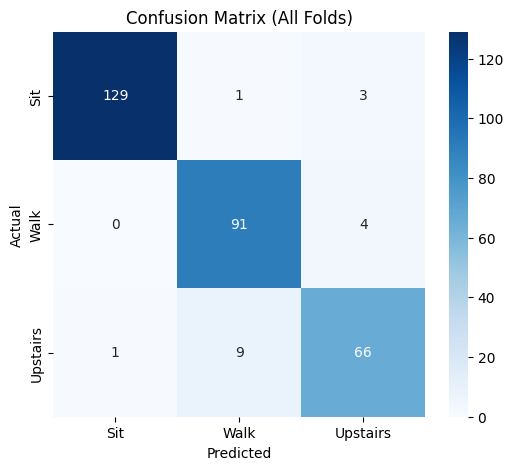


Classification Report:
              precision    recall  f1-score   support

         Sit       0.99      0.97      0.98       133
        Walk       0.90      0.96      0.93        95
    Upstairs       0.90      0.87      0.89        76

    accuracy                           0.94       304
   macro avg       0.93      0.93      0.93       304
weighted avg       0.94      0.94      0.94       304



In [12]:
if __name__ == "__main__":
    train_and_evaluate()